In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mogli
import os
from ipywidgets import IntProgress
from IPython.display import display

In [ ]:
bandgaps = np.loadtxt('Datasets/bandgaps.csv')
cods = np.loadtxt('Datasets/CODids.csv', dtype=int)
materials = mogli.read('Datasets/structures.xyz')

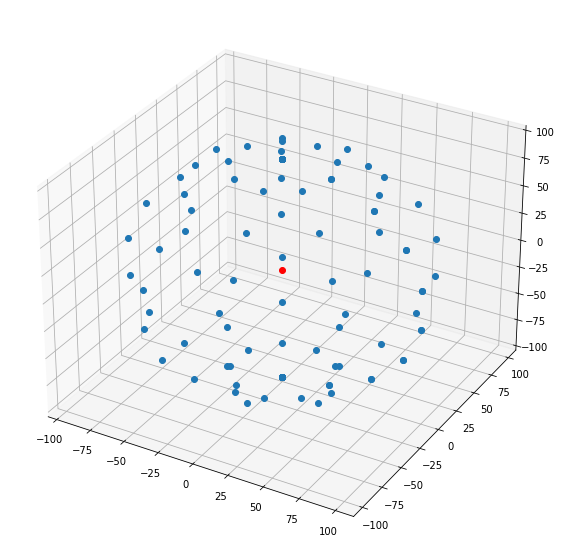

In [24]:

# array with point of sphere  in 3D space

def sphere(radius, n):
    phi = np.linspace(0, np.pi, n)
    theta = np.linspace(0, 2*np.pi, n)
    x = radius*np.outer(np.sin(phi), np.cos(theta))
    y = radius*np.outer(np.sin(phi), np.sin(theta))
    z = radius*np.outer(np.cos(phi), np.ones_like(theta))
    # put x,y, and z as columns in a matrix
    
    return np.column_stack((x.flatten(),y.flatten(),z.flatten()))

s = sphere(100, 10)

plt.figure(figsize=(10,10))

# make a 3d plot
ax = plt.axes(projection='3d')

# Data for a three-dimensional line

ax.plot3D(s[:,0], s[:,1], s[:,2], 'o')
ax.plot3D(0,0,0, 'red', marker='o')

In [ ]:
from PIL import Image

In [21]:
bonds_param = 1.55
width = 512
height = 512
distance = 100

path = f'Datasets/3d/{width}x{height}_BP{bonds_param}/f1'
if not os.path.exists(path):
    os.makedirs(path)    
for i, molecule in enumerate(materials):
    for n,rotation in enumerate(sphere(distance, 10)):
        # print(f'{i} {rotation}')     
        mogli.export(molecule,f"{path}/molecula_{i}_{n}.jpg",bonds_param=bonds_param,camera=((rotation[0],rotation[1],0),(0, 0, 0),(0 , 0 , 1)), width=width, height=height)
        # # put withe background in png
        # img = Image.open(f"{path}/molecula_{i}_{n}.png")
        # img = img.convert("RGBA")
        # # save with white background
        # datas = img.getdata()
        # img.save(f"{path}/molecula_{i}_{n}.png", "PNG")
        
    break

In [ ]:
bonds_param = 1.25
width = 512
height = 512

path = f'Datasets/3d/{width}x{height}_BP{bonds_param}'
print(path)


distance = 25

if not os.path.exists(path):
    os.makedirs(path)    
if not os.path.exists(f"{path}/enfrente"):
    os.makedirs(f"{path}/enfrente")
if not os.path.exists(f"{path}/atras"):
    os.makedirs(f"{path}/atras")
if not os.path.exists(f"{path}/Izquierda"):
    os.makedirs(f"{path}/Izquierda")
if not os.path.exists(f"{path}/Derecha"):
    os.makedirs(f"{path}/Derecha")
if not os.path.exists(f"{path}/abajo"):
    os.makedirs(f"{path}/abajo")
if not os.path.exists(f"{path}/arriba"):
    os.makedirs(f"{path}/arriba")    

f = IntProgress(min=0, max=len(materials)) 

f.description = 'Progress: '
f.bar_style = 'info'
f.layout.width = '100%'
display(f)

for i, molecule in enumerate(materials):
    # frente 
    mogli.export(molecule,f"{path}/enfrente/enfrente_{i}.png",bonds_param=bonds_param,camera=((distance, 0, 0),(0, 0, 0),(0 , 1 , 0)), width=width, height=height)
    # atras
    mogli.export(molecule,f"{path}/atras/atras_{i}.png",bonds_param=bonds_param,camera=((-distance, 0, 0),(0, 0, 0),(0, 1 , 0)), width=width, height=height)

    # 90 grados derecha 
    mogli.export(molecule,f"{path}/Izquierda/Izquierda_{i}.png",bonds_param=bonds_param,camera=((0, 0, distance),(0, 0, 0),(0,1, 0)), width=width, height=height)
    # 90 grados izquierda
    mogli.export(molecule,f"{path}/Derecha/Derecha_{i}.png",bonds_param=bonds_param,camera=((0, 0, distance),(0, 0, 0),(0, -1, 0)), width=width, height=height)

    # abajo
    mogli.export(molecule,f"{path}/abajo/abajo_{i}.png",bonds_param=bonds_param,camera=((0, -distance, 0),(0, 0, 0),(1, 0, 0)), width=width, height=height)
    # arriba
    mogli.export(molecule,f"{path}/arriba/arriba_{i}.png",bonds_param=bonds_param,camera=((0, distance, 0),(0, 0, 0),(-1, 0, 0)), width=width, height=height)
    f.value += 1